In [20]:
from dataclasses import dataclass
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from abc import ABC, abstractmethod

In [21]:
@dataclass
class TrainConfig:
    push_to_hub = "Xsmos/ml21cm"
    hub_private_repo = False
    dataset_name = "/storage/home/hcoda1/3/bxia34/scratch/LEN512-DIM256.h5"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_batch_size = 5


config = TrainConfig()

In [126]:
!h5dump -H /storage/home/hcoda1/3/bxia34/scratch/LEN512-DIM256.h5

HDF5 "/storage/home/hcoda1/3/bxia34/scratch/LEN512-DIM256.h5" {
GROUP "/" {
   DATASET "brightness_temp" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 600, 256, 256, 514 ) / ( H5S_UNLIMITED, 256, 256, 514 ) }
   }
   DATASET "density" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 600, 256, 256, 514 ) / ( H5S_UNLIMITED, 256, 256, 514 ) }
   }
   DATASET "kwargs" {
      DATATYPE  H5T_STRING {
         STRSIZE H5T_VARIABLE;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_UTF8;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SIMPLE { ( 21, 2 ) / ( 21, 2 ) }
   }
   GROUP "params_seeds" {
      DATASET "keys" {
         DATATYPE  H5T_STRING {
            STRSIZE H5T_VARIABLE;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_UTF8;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SIMPLE { ( 3 ) / ( 3 ) }
      }
      DATASET "values" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 600, 3 ) / ( H5S_UNLIMITED,

In [86]:
class Dataset4h5(Dataset):
    def __init__(self, dir_name, num_image=10, field='brightness_temp', random=False, idx=None, num_redshift=16):
        self.dir_name = dir_name
        self.num_image = num_image
        self.field = field
        self.random = random
        self.idx = idx
        self.num_redshift = num_redshift

        self.load_h5()

        self.len = len(self.params)
        self.images = torch.from_numpy(self.images)
        self.params = torch.from_numpy(self.params)

    def load_h5(self):
        with h5py.File(self.dir_name, 'r') as f:
            print(f"content: {f.keys()}")
            max_num_image = f['brightness_temp'].shape[0]
            print(f"{max_num_image} images can be loaded")

            if self.idx is None:
                if self.random:
                    self.idx = np.sort(random.sample(range(max_num_image), self.num_image))
                    print(f"loading {self.num_image} images randomly")
                    # print(self.idx)
                else:
                    self.idx = range(self.num_image)
                    print(f"loading {len(self.idx)} images with idx = {self.idx}")
            else:
                print(f"loading {len(self.idx)} images with idx = {self.idx}")

            self.params = f['params_seeds']['values'][self.idx,:2]
            print("params loaded:", self.params.shape)
            
            self.images = f[self.field][self.idx,:,:,:self.num_redshift]
            print(f"{self.field} loaded:", self.images.shape)

    def __getitem__(self, index):
        return self.images[index], self.params[index]

    def __len__(self):
        return self.len

# dataset = Dataset4h5(config.dataset_name, random=True, num_image=10, num_redshift=1)
dataset = Dataset4h5(config.dataset_name)
train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances', 'xH_box']>
600 images can be loaded
loading 10 images with idx = range(0, 10)
params loaded: (10, 2)
brightness_temp loaded: (10, 256, 256, 16)


Text(0.5, 1.0, 'tensor([  5.6638, 173.4913], dtype=torch.float64)')

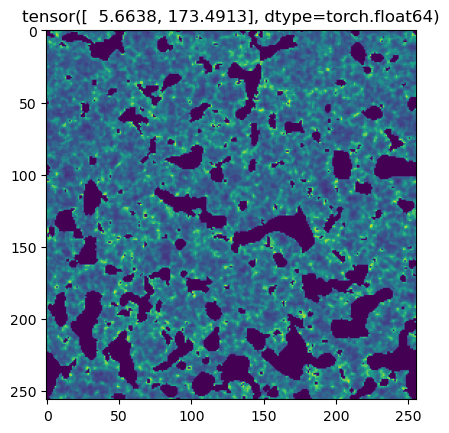

In [87]:
img, label = next(iter(train_dataloader))
idx = 0
plt.imshow(img[idx][:,:,0])
plt.title(label[idx])

# Add noise:

\begin{align*}
x_t &\sim \mathcal N\left(\sqrt{1-\beta_t}\ x_{t-1},\ \beta_t \right) \\
x_t &\equiv \sqrt{1-\beta_t}\ x_{t-1} + \sqrt{\beta_t}\ \epsilon\\
\epsilon &\sim \mathcal N(0,1)\\
\alpha_t & \equiv 1 - \beta_t\\
& ...\\
x_t &= \sqrt{\bar {\alpha_t}} x_0 + \epsilon\ \sqrt{1 - \bar{\alpha_t}}\\
\bar {\alpha_t} &\equiv \prod_{i=1}^t \alpha_i\\
&= \exp\left({\ln{\prod_{i=1}^t \alpha_i}}\right)\\
&= \exp\left({\sum_{i=1}^t\ln{ \alpha_i}}\right)
\end{align*}

In [88]:
class DDPMScheduler:
    def __init__(self, beta_1, beta_T, num_train_timesteps):
        assert 0 < beta_1 <= beta_T <= 1, "ensure 0 < beta_1 <= beta_T <= 1"
        self.num_train_timesteps = num_train_timesteps
        self.beta_t = torch.linspace(beta_1, beta_T, self.num_train_timesteps) * (beta_T-beta_1) + beta_1

        self.alpha_t = 1 - self.beta_t
        self.bar_alpha_t = np.exp(np.cumsum(np.log(self.alpha_t)))

    def add_noise(self, clean_images):
        noise = torch.randn_like(clean_images)
        ts = torch.randint(0, self.num_train_timesteps, (clean_images.shape[0],))
        # print(clean_images.shape)
        # print(noise.shape)
        # print(ts.shape)
        # print(torch.sqrt(self.bar_alpha_t[ts])[:, None, None, None].shape)
        noisy_images = (
            clean_images * torch.sqrt(self.bar_alpha_t[ts])[:, None, None, None]
            + noise * torch.sqrt(1-self.bar_alpha_t[ts])[:, None, None, None]
            )
        # print(x_t.shape)
        return noisy_images, noise, ts

ddpm_scheduler = DDPMScheduler(1e-4,0.2,1000)
noisy_images, noise, ts = ddpm_scheduler.add_noise(img)

tensor([ 88, 122, 995, 592, 426])
torch.Size([5, 256, 256, 16])
tensor(56.5750) tensor(-4.8423)


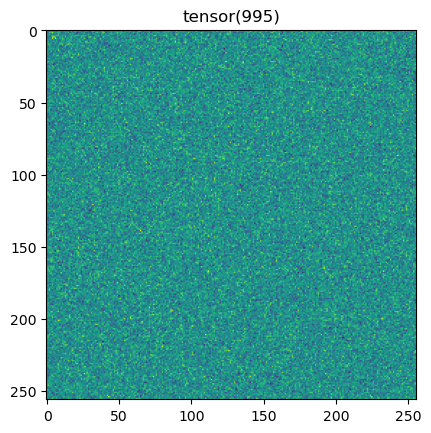

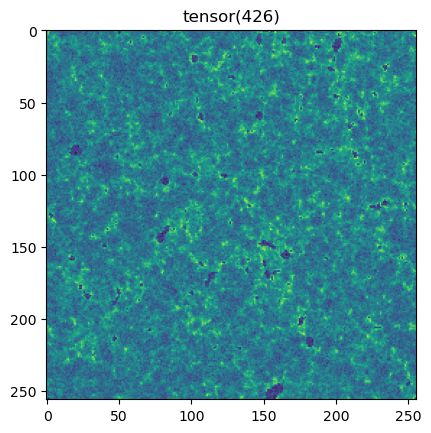

In [91]:
print(ts)
print(noisy_images.shape)
print(noisy_images.max(), noisy_images.min())
plt.imshow(noisy_images[2,:,:,0])
plt.title(ts[2])
plt.show()
plt.imshow(noisy_images[4,:,:,0])
plt.title(ts[4])
plt.show()

In [112]:
print(img.shape)
img_expand = np.expand_dims(img, axis=1)
print(img_expand.shape)
print(type(img_expand))
m = nn.BatchNorm3d(num_features=1)
img_norm = m(torch.tensor(img_expand))
print(img_norm.shape)

torch.Size([5, 256, 256, 16])
(5, 1, 256, 256, 16)
<class 'numpy.ndarray'>
torch.Size([5, 1, 256, 256, 16])


In [110]:
print(img.max())
print(img.min())
print(img.mean())
print(img_norm.max())
print(img_norm.min())
print(img_norm.mean())

tensor(69.1072)
tensor(0.)
tensor(21.6305)
tensor(4.4395, grad_fn=<MaxBackward1>)
tensor(-2.0227, grad_fn=<MinBackward1>)
tensor(1.3085e-07, grad_fn=<MeanBackward0>)


In [117]:
m = nn.Identity()
img_identity = m(img_norm)
print(np.unique(img_identity == img_norm))

[ True]


In [120]:
m = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
img_conv = m(img_identity)
print(img_conv.shape)

torch.Size([5, 1, 256, 256, 16])


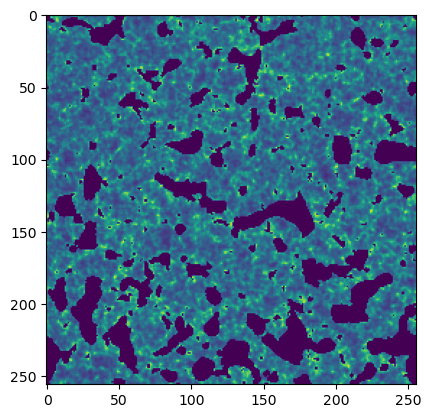

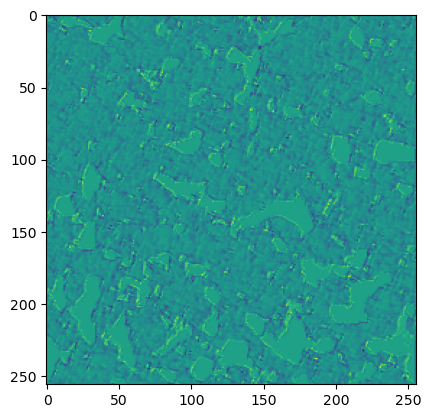

In [124]:
plt.imshow(img[0,...,0].detach())
plt.show()
plt.imshow(img_conv[0,0,...,0].detach())
plt.show()

In [151]:
class Downsample(nn.Module):
    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        stride = (2,2,2)
        if use_conv:
            # print("conv")
            self.op = nn.Conv3d(channels, self.out_channels, 3, stride=stride, padding=1)
        else:
            # print("pool")
            assert channels == self.out_channels
            self.op = nn.AvgPool3d(kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)

torch.Size([5, 1, 256, 256, 16])
conv
torch.Size([5, 1, 128, 128, 8])


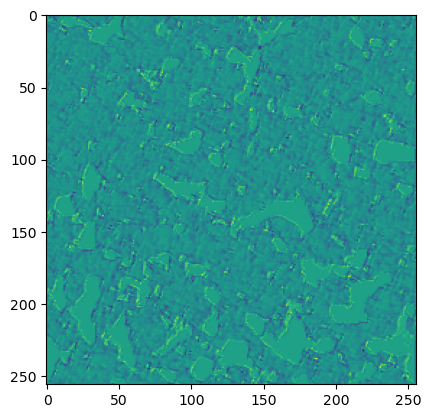

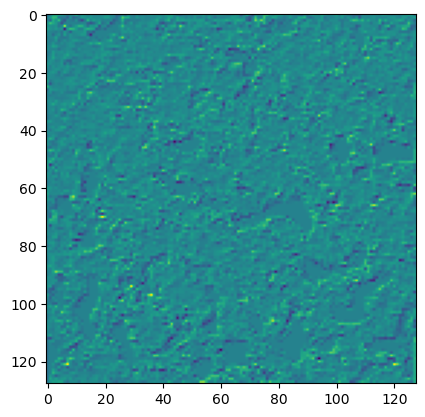

In [156]:
print(img_conv.shape)
down = Downsample(1,True)
img_down = down(img_conv)
print(img_down.shape)
plt.imshow(img_conv[0,0,...,0].detach())
plt.show()
plt.imshow(img_down[0,0,...,0].detach())
plt.show()

torch.Size([5, 1, 256, 256, 16])
pool
torch.Size([5, 1, 128, 128, 8])


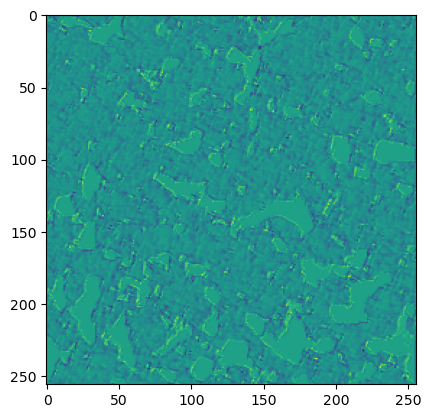

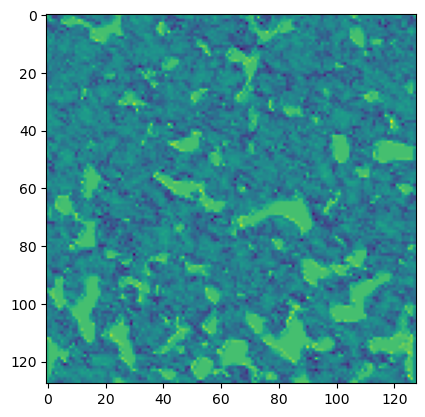

In [157]:
print(img_conv.shape)
down = Downsample(1,False)
img_down = down(img_conv)
print(img_down.shape)
plt.imshow(img_conv[0,0,...,0].detach())
plt.show()
plt.imshow(img_down[0,0,...,0].detach())
plt.show()

In [52]:
class TimestepBlock(ABC, nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        test
        """

In [56]:
class ResBlock(TimestepBlock):
    def __init__(
        self, channels, emb_channels, dropout, out_channels=None, use_conv=False, use_scale_shift_norm=False, dims=2, use_checkpoint=False, up=False, down=False,
        ):
        self.out_channels = out_channels or channels
        self.updown = up or down

        super().__init__()
        self.in_layers = nn.Sequential(
            nn.BatchNorm3d(num_channels=channels), # normalize to standard gaussian
            nn.Identity(),
            nn.Conv3d(channels, self.out_channels, 3, padding=1),
        )

    def forward(self, x, emb):
        print("forward in ResBlock has been made")

In [8]:
class ContextUnet(nn.Module):
    def __init__(self):
        pass

In [23]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
print(torch.cuda.is_available())
print(torch.__path__)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

True
['/usr/local/pace-apps/manual/packages/pytorch/1.12.0/lib/python3.9/site-packages/torch']


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

True
Quadro RTX 6000
1


In [48]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

torch.Size([32, 32])


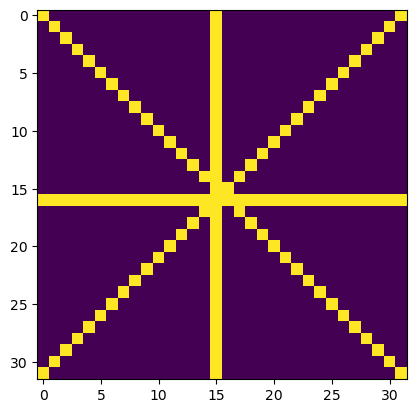

torch.Size([1, 32, 32])


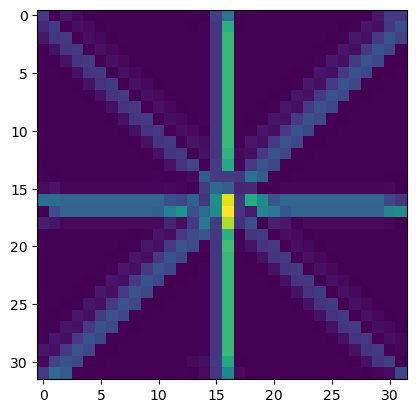

In [49]:
ResConv = ResidualConvBlock(1,1, is_res=True)
x = torch.eye(32)
# x = torch.stack((x,x/2,x/3), axis=0)
# x = x.reshape(3,16,16)
print(x.shape)
x[int(x.shape[0]/2),:] = 1
x[:, int(x.shape[1]/2)-1] = 1
np.fill_diagonal(x.numpy()[:,::-1], 1)
# plt.imshow(x.permute(1,2,0))
plt.imshow(x)
plt.show()
# x = np.expand_dims(x, axis=0)
x = x[None, :]
print(x.shape)
# ResConv_out = ResConv.forward(torch.stack((x,x/2), axis=0))
ResConv_out = ResConv.forward(x[None,:])
ResConv_out.shape
plt.imshow(ResConv_out[0][0].detach())
# plt.imshow(ResConv_out[0].permute(1,2,0).detach())
plt.show()
# plt.imshow(ResConv_out[1].permute(1,2,0).detach())
# plt.imshow(ResConv_out[1][0].detach())
# plt.show()

torch.Size([32, 32])


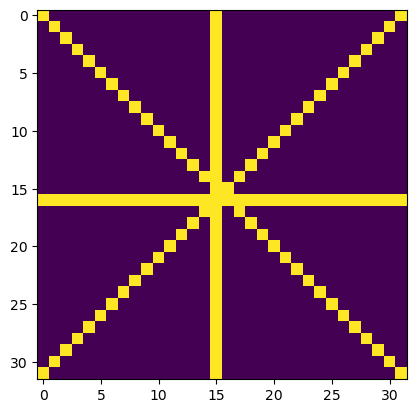

torch.Size([1, 32, 32])


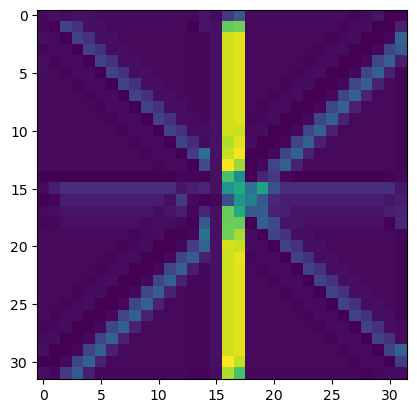

In [50]:
ResConv = ResidualConvBlock(1,1, is_res=False)
x = torch.eye(32)
# x = torch.stack((x,x/2,x/3), axis=0)
# x = x.reshape(3,16,16)
print(x.shape)
x[int(x.shape[0]/2),:] = 1
x[:, int(x.shape[1]/2)-1] = 1
np.fill_diagonal(x.numpy()[:,::-1], 1)
# plt.imshow(x.permute(1,2,0))
plt.imshow(x)
plt.show()
# x = np.expand_dims(x, axis=0)
x = x[None, :]
print(x.shape)
# ResConv_out = ResConv.forward(torch.stack((x,x/2), axis=0))
ResConv_out = ResConv.forward(x[None,:])
ResConv_out.shape
plt.imshow(ResConv_out[0][0].detach())
# plt.imshow(ResConv_out[0].permute(1,2,0).detach())
plt.show()
# plt.imshow(ResConv_out[1].permute(1,2,0).detach())
# plt.imshow(ResConv_out[1][0].detach())
# plt.show()

In [8]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        # print("x.shape =", x.shape)
        # print("skip.shape =", skip.shape)
        x = torch.cat((x, skip), 1)
        # print(x)
        x = self.model(x)
        # print(x)
        return x

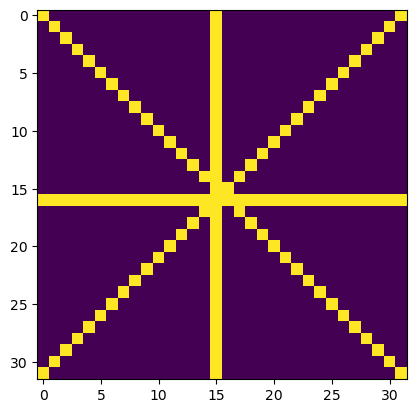

torch.Size([2, 1, 16, 16])


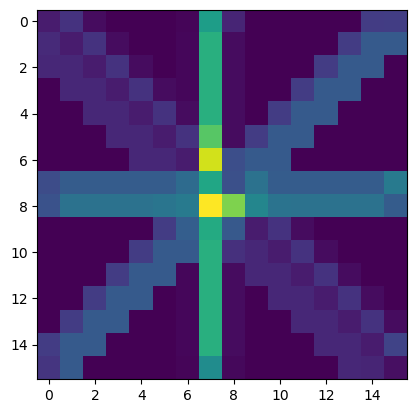

In [10]:
plt.imshow(x[0])
plt.show()
down = UnetDown(1,1).forward(torch.stack((x,x/2), axis=0))
print(down.shape)
plt.imshow(down.detach()[0][0])
plt.show()
# plt.imshow(x[0])
# plt.show()
# plt.imshow(UnetUp(1,1).forward(torch.stack((x,x/2), axis=0), skip=down.detach()))
# plt.show()

In [11]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [12]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super().__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2*n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2*n_feat, 2*n_feat, 7, 7),
            nn.GroupNorm(8, 2*n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4*n_feat, n_feat)
        self.up2 = UnetUp(2*n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2*n_feat, n_feat, 3,1,1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3,1,1),
        )
    
    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = (-1*(1-context_mask))
        c = c*context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat*2, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat*2, 1,1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1,1)
        
        up1 = self.up0(hiddenvec)
        # print("cemb.shape =", cemb1.shape, up1.shape, temb1.shape, down2.shape)
        up2 = self.up1(cemb1*up1 + temb1, down2)
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))

        return out

In [13]:
def ddpm_scheduler(beta1, beta2, T):
    assert 0 < beta1 < beta2 < 1.0, "make sure 0 < beta1 < beta2 < 1"
    beta_t = torch.linspace(0,1,T, dtype=torch.float32)*(beta2-beta1) + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1/torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

    return_list = ["alpha_t", "oneover_sqrta", "sqrt_beta_t", "alphabar_t", "sqrtab", "sqrtmab", "mab_over_sqrtmab"]
    
    return_dict = {}
    for key in return_list:
        return_dict[key] = locals()[key]
 
    return return_dict

In [14]:
test_tensor = torch.randn(2,3)
print(test_tensor)
print(test_tensor.shape)
print(type(test_tensor.shape))
print(torch.Tensor(test_tensor.shape))
print(torch.Tensor((2.222,3)))

tensor([[-0.4731, -0.0678, -0.4464],
        [ 1.7556,  0.8053,  0.0158]])
torch.Size([2, 3])
<class 'torch.Size'>
tensor([[1.0190e+16, 3.0611e-41, 8.7985e+15],
        [3.0611e-41, 8.9683e-44, 0.0000e+00]])
tensor([2.2220, 3.0000])


In [15]:
class test_buffer(nn.Module):
    def __init__(self):
        super().__init__()
        print(self.__dict__)
        my_dict = dict(a=1, b=999, c=3)
        for k, v in my_dict.items():
            self.register_buffer(k,torch.Tensor([v]))
        # print(self.__dict__)

test = test_buffer()
print(test.a.shape, test.b.shape, test.c.shape)
print(test.a, test.b, test.c)

{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict()}
torch.Size([1]) torch.Size([1]) torch.Size([1])
tensor([1.]) tensor([999.]) tensor([3.])


In [16]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        "计算如何依次增加噪音"
        super().__init__()
        self.nn_model = nn_model.to(device)
            
        for k, v in ddpm_scheduler(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)
        noise = torch.randn_like(x)
        # print("_ts: shape = ", _ts.shape, "max =", _ts.max())
        x_t = (
            self.sqrtab[_ts, None, None, None] * x +
            self.sqrtmab[_ts, None, None, None] * noise
        )

        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        noise_pred = self.nn_model(x_t, c, _ts/self.n_T, context_mask)
        
        return self.loss_mse(noise, noise_pred)

    def sample(self, n_sample, size, device, guide_w = 0):
        x_i = torch.randn(n_sample, *size).to(device)
        c_i = torch.arange(0,10).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        context_mask = torch.zeros_like(c_i).to(device)

        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1

        x_i_store = []
        print()
        for i in range(self.n_T-1, 0, -1):
            print(f"sampling timestep {i}", end='\r')
            t_is = torch.Tensor([i/self.n_T]).to(device)
            t_is = t_is.repeat(n_sample, 1,1,1)

            t_is = t_is.repeat(2,1,1,1)
            x_i = x_i.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 0 else 0

            # print(x_i.shape, c_i.shape, t_is.shape, context_mask.shape)
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            # print("eps.shape =", eps.shape)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2

            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps*self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z 
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [17]:
n_epoch = 20
batch_size = 256
n_T = 400
device = "cuda:0" if torch.cuda.is_available() else "cpu" #"cpu" #
n_classes = 10
n_feat = 128
lrate = 1e-4
save_model = False
save_dir = "./data/diffusion_outputs10/"
ws_test = [0, 0.5, 2]

nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes)
ddpm = DDPM(nn_model=nn_model, betas=(1e-4,0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()])

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

In [18]:
print(optim.param_groups[0].keys())
print(optim.param_groups[0]['lr'])

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable'])
0.0001


In [19]:
pbar = tqdm(dataloader)
for x, c in pbar:
    print(x.shape, c.shape)
    break
print(x.shape, c.shape)

  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [20]:
loss = ddpm(x.to(device),c.to(device))
print(loss)
print(loss.item())

tensor(1.1110, device='cuda:0', grad_fn=<MseLossBackward0>)
1.1109533309936523


In [21]:
test1 = torch.randn(2,3)
print(test1.shape)
test2 = torch.Tensor(test1.shape)
print(test2)
print(test2.shape)

torch.Size([2, 3])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.Size([2, 3])


epoch 0


loss: 0.0483: 100%|██████████| 235/235 [00:41<00:00,  5.64it/s]



save image at ./data/diffusion_outputs10/ image_ep0_w0.png
save image at ./data/diffusion_outputs10/ gif_ep0_w0.gif

save image at ./data/diffusion_outputs10/ image_ep0_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep0_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep0_w2.png
save image at ./data/diffusion_outputs10/ gif_ep0_w2.gif
epoch 1


loss: 0.0375: 100%|██████████| 235/235 [00:39<00:00,  5.99it/s]



save image at ./data/diffusion_outputs10/ image_ep1_w0.png

save image at ./data/diffusion_outputs10/ image_ep1_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep1_w2.png
epoch 2


loss: 0.0349: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]



save image at ./data/diffusion_outputs10/ image_ep2_w0.png

save image at ./data/diffusion_outputs10/ image_ep2_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep2_w2.png
epoch 3


loss: 0.0319: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep3_w0.png

save image at ./data/diffusion_outputs10/ image_ep3_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep3_w2.png
epoch 4


loss: 0.0309: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep4_w0.png

save image at ./data/diffusion_outputs10/ image_ep4_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep4_w2.png
epoch 5


loss: 0.0292: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep5_w0.png
save image at ./data/diffusion_outputs10/ gif_ep5_w0.gif

save image at ./data/diffusion_outputs10/ image_ep5_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep5_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep5_w2.png
save image at ./data/diffusion_outputs10/ gif_ep5_w2.gif
epoch 6


loss: 0.0284: 100%|██████████| 235/235 [00:39<00:00,  5.98it/s]



save image at ./data/diffusion_outputs10/ image_ep6_w0.png

save image at ./data/diffusion_outputs10/ image_ep6_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep6_w2.png
epoch 7


loss: 0.0282: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]



save image at ./data/diffusion_outputs10/ image_ep7_w0.png

save image at ./data/diffusion_outputs10/ image_ep7_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep7_w2.png
epoch 8


loss: 0.0275: 100%|██████████| 235/235 [00:39<00:00,  5.91it/s]



save image at ./data/diffusion_outputs10/ image_ep8_w0.png

save image at ./data/diffusion_outputs10/ image_ep8_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep8_w2.png
epoch 9


loss: 0.0273: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep9_w0.png

save image at ./data/diffusion_outputs10/ image_ep9_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep9_w2.png
epoch 10


loss: 0.0268: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep10_w0.png
save image at ./data/diffusion_outputs10/ gif_ep10_w0.gif

save image at ./data/diffusion_outputs10/ image_ep10_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep10_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep10_w2.png
save image at ./data/diffusion_outputs10/ gif_ep10_w2.gif
epoch 11


loss: 0.0263: 100%|██████████| 235/235 [00:39<00:00,  5.98it/s]



save image at ./data/diffusion_outputs10/ image_ep11_w0.png

save image at ./data/diffusion_outputs10/ image_ep11_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep11_w2.png
epoch 12


loss: 0.0260: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]



save image at ./data/diffusion_outputs10/ image_ep12_w0.png

save image at ./data/diffusion_outputs10/ image_ep12_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep12_w2.png
epoch 13


loss: 0.0261: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep13_w0.png

save image at ./data/diffusion_outputs10/ image_ep13_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep13_w2.png
epoch 14


loss: 0.0257: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep14_w0.png

save image at ./data/diffusion_outputs10/ image_ep14_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep14_w2.png
epoch 15


loss: 0.0255: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]



save image at ./data/diffusion_outputs10/ image_ep15_w0.png
save image at ./data/diffusion_outputs10/ gif_ep15_w0.gif

save image at ./data/diffusion_outputs10/ image_ep15_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep15_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep15_w2.png
save image at ./data/diffusion_outputs10/ gif_ep15_w2.gif
epoch 16


loss: 0.0256: 100%|██████████| 235/235 [00:39<00:00,  5.99it/s]



save image at ./data/diffusion_outputs10/ image_ep16_w0.png

save image at ./data/diffusion_outputs10/ image_ep16_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep16_w2.png
epoch 17


loss: 0.0254: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]



save image at ./data/diffusion_outputs10/ image_ep17_w0.png

save image at ./data/diffusion_outputs10/ image_ep17_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep17_w2.png
epoch 18


loss: 0.0251: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]



save image at ./data/diffusion_outputs10/ image_ep18_w0.png

save image at ./data/diffusion_outputs10/ image_ep18_w0.5.png

save image at ./data/diffusion_outputs10/ image_ep18_w2.png
epoch 19


loss: 0.0245: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]



save image at ./data/diffusion_outputs10/ image_ep19_w0.png
save image at ./data/diffusion_outputs10/ gif_ep19_w0.gif

save image at ./data/diffusion_outputs10/ image_ep19_w0.5.png
save image at ./data/diffusion_outputs10/ gif_ep19_w0.5.gif

save image at ./data/diffusion_outputs10/ image_ep19_w2.png
save image at ./data/diffusion_outputs10/ gif_ep19_w2.gif


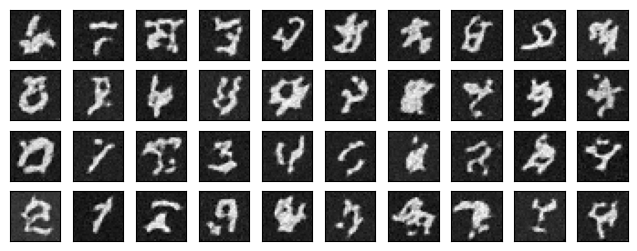

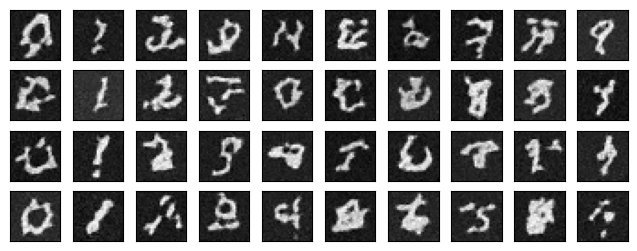

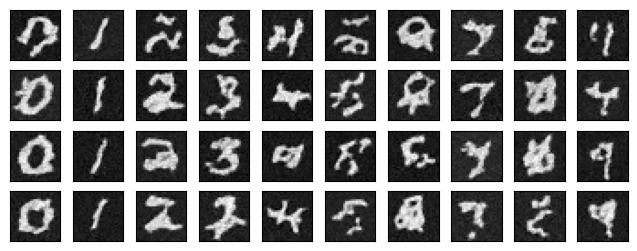

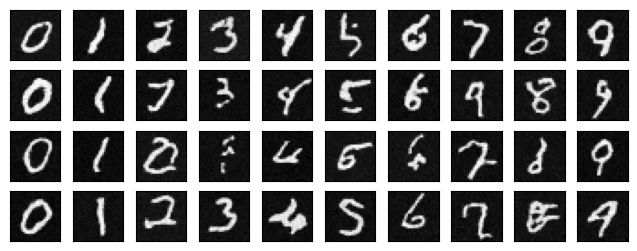

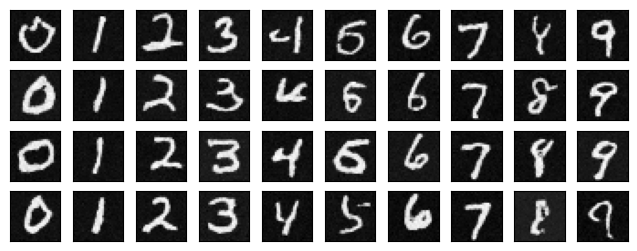

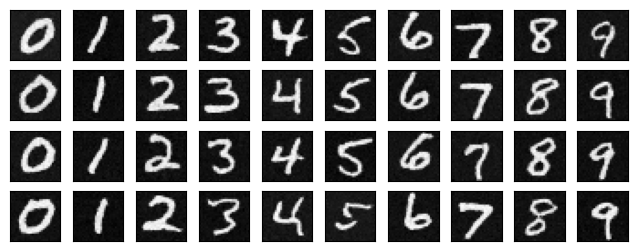

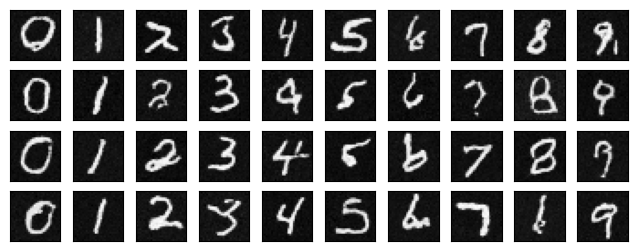

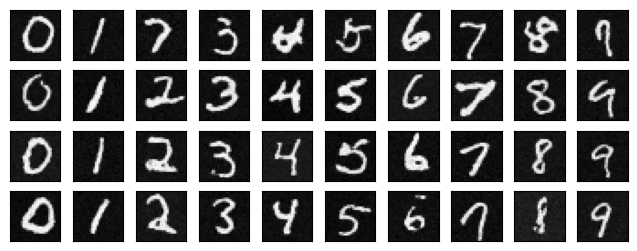

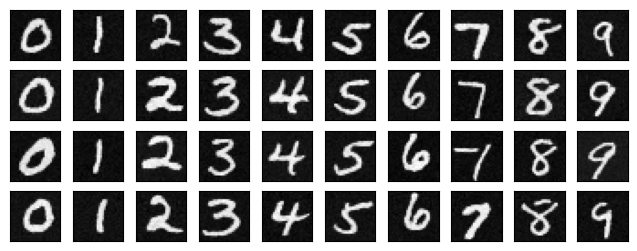

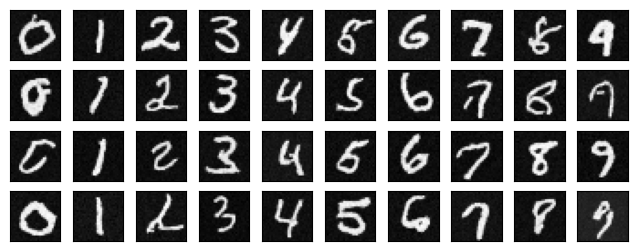

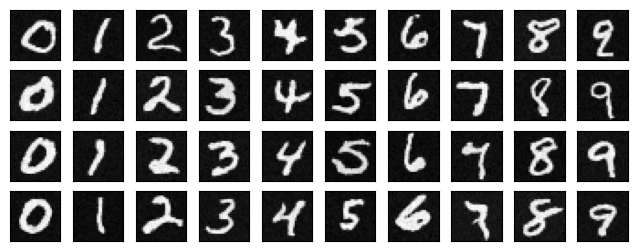

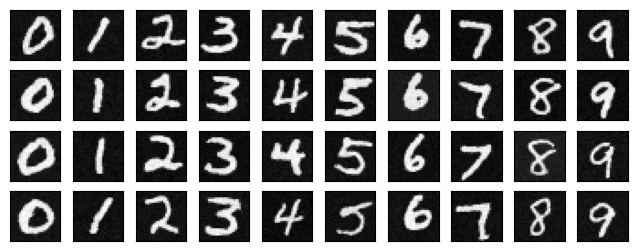

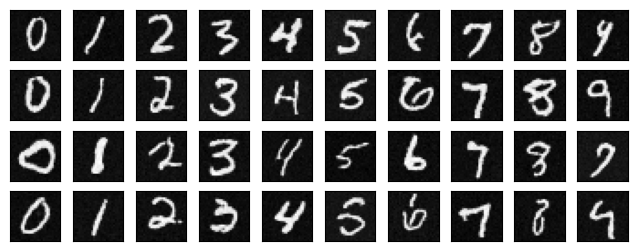

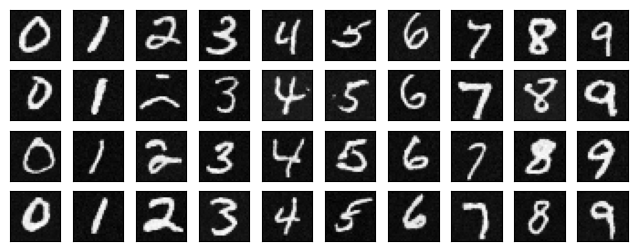

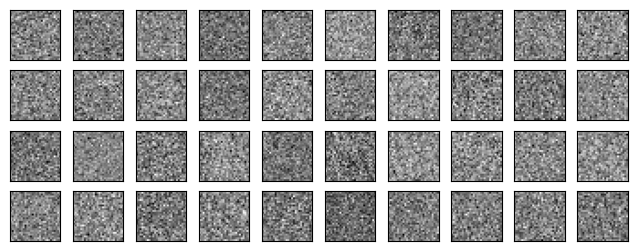

In [22]:
for ep in range(n_epoch):
    print(f"epoch {ep}")
    ddpm.train()

    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None

    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c) # 计算损失函数大小
        loss.backward() # 计算损失函数斜率
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step() # 更新神经网络参数值

    ddpm.eval()
    with torch.no_grad():
        n_sample = 4 * n_classes
        for w_i, w in enumerate(ws_test):
            # print("w_i, w =", w_i, w)
            x_gen, x_gen_store = ddpm.sample(n_sample, (1,28,28), device, guide_w=w)
            # print("x_gen.shape =", x_gen.shape, "x_gen_store.shape =", x_gen_store.shape)
            x_real = torch.Tensor(x_gen.shape).to(device)
            # print("x_real.shape =", x_real.shape)
            for k in range(n_classes):
                for j in range(int(n_sample/n_classes)):
                    try:
                        idx = torch.squeeze((c==k).nonzero())[j]
                    except:
                        idx = 0
                    # print("k+j*n_classes =", k+j*n_classes, "idx =", idx)
                    x_real[k+j*n_classes] = x[idx]

            # print("x_gen.shape =", x_gen.shape, "x_real.shape =", x_real.shape)
            x_all = torch.cat([x_gen, x_real])
            # print("x_all.shape =", x_all.shape)
            grid = make_grid(x_all*-1+1, nrow=10)
            # print("save start")
            save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
            print("save image at", save_dir, f"image_ep{ep}_w{w}.png")

            if ep%5==0 or ep==int(n_epoch-1):
                fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                def animate_diff(i, x_gen_store):
                    print(f"gif animating frame {i} of {x_gen_store.shape[0]}", end="\r")
                    plots = []
                    for row in range(int(n_sample/n_classes)):
                        for col in range(n_classes):
                            # print("row =", row, "col =", col)
                            axs[row, col].clear()
                            axs[row, col].set_xticks([])
                            axs[row, col].set_yticks([])
                            plots.append(axs[row, col].imshow(
                                x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                            # plots.append(axs[row,col].imshow(
                            #     -x_gen_store[i,row*n_classes+col,0],
                            #     cmap='gray', vmin=-x_gen_store[i].min(),
                            #     vmax=-x_gen_store[i].max()
                            # ))
                    return plots
                ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store], interval=200,blit=False,repeat=True,frames=x_gen_store.shape[0])
                ani.save(save_dir+f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                print("save image at", save_dir, f"gif_ep{ep}_w{w}.gif")

    if save_model and ep == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir+f"model_{ep}.pth")
        print("save model at", save_dir, f"model_{ep}.pth")

In [1]:
from huggingface_hub import notebook_login
notebook_login()
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel

@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()


config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), num_processes=1)

# test on 21cm dataset

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import numpy as np
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
import h5py
from datasets import Dataset

@dataclass
class TrainingConfig:
    image_size = [64,512]
    train_batch_size = 16
    eval_batch_size = 24
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 10
    mixed_precision = 'fp16'
    output_dir = "diffusion21cm"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()
# config.dataset_name = "diffusion21cm"
# dataset = load_dataset(config.dataset_name, split='train')

In [3]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64.h5", 'r') as f:
    print(f.keys())
    print(f['brightness_temp'])
    Tb = f['brightness_temp'][:1000,0,:,:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances']>
<HDF5 dataset "brightness_temp": shape (30000, 64, 64, 514), type "<f4">


(1000, 64, 514)
<class 'numpy.ndarray'>


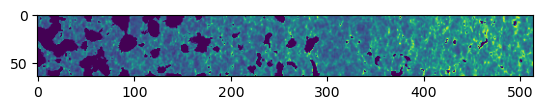

In [4]:
print(Tb.shape)
print(type(Tb))
# plt.imshow(Tb[0])
plt.imshow(Tb[0])

In [5]:
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split='train')
# print(dataset.shape)
# print(type(dataset))
# print(dataset)
# print(dataset[0]['image'].convert('RGB'))
# print(np.shape(dataset[0]['image']))
# dataset[0]['image'].convert('RGB')

In [6]:
def load_numpy_dataset(np_array, split='train'):
    assert split in ['train', 'test', 'validation'], "Invalid split name. Use 'train', 'test', or 'validation'."
    dataset = Dataset.from_dict({'image': np_array})
    return dataset
dataset = load_numpy_dataset(Tb)
print(type(dataset))
print(len(dataset))
print(np.shape(dataset))
print(dataset)
print(np.shape(dataset[0]['image']))

<class 'datasets.arrow_dataset.Dataset'>
1000
(1000, 1)
Dataset({
    features: ['image'],
    num_rows: 1000
})
(64, 514)


(64, 514)
0.0 62.48933029174805


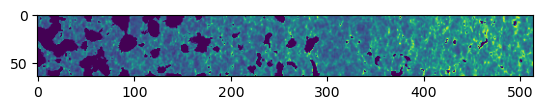

In [7]:
test = np.array(dataset[0]['image'])
print(test.shape)
print(test.min(), test.max())
test = (test-test.min())/(test.max()-test.min())
# plt.imshow((test*255).astype(np.int))
plt.imshow(test)
plt.show()

In [8]:
def normalize(image):
    initial_data = np.array(image)
    data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())
    # data = (normalized_data*255).astype(np.uint8)
    data = Image.fromarray(np.uint8(data*255))
    return data

preprocess = transforms.Compose(
    [
        # normalize(),
        transforms.Resize((config.image_size[0], config.image_size[1])),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(normalize(image)) for image in examples['image']]
    # images = [preprocess(image) for image in examples['image']]
    # print(np.shape(images[0]))
    return {"images": images}

# datasets = transform(Tb)
dataset.set_transform(transform)

In [9]:
dataset[0]['images'].shape

torch.Size([1, 64, 512])

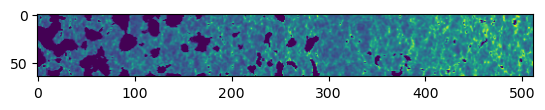

In [10]:
plt.imshow(dataset[0]['images'][0])

In [11]:
# dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [12]:
next(iter(train_dataloader))['images'].shape

torch.Size([16, 1, 64, 512])

In [13]:
model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=12, cols=2)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
    
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)


In [14]:
# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

/scratch/5495298/ipykernel_22069/2220207547.py:3: RuntimeWarning: invalid value encountered in true_divide
  data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712107271.atl1-1-03-004-33-0.pace.gatech.edu.90591.0:   0%|          | 0.00/25.9k [00:00<…

events.out.tfevents.1712107175.atl1-1-03-004-33-0.pace.gatech.edu.1952.0:   0%|          | 0.00/1.45k [00:00<?…

events.out.tfevents.1712109728.atl1-1-03-004-33-0.pace.gatech.edu.252572.0:   0%|          | 0.00/91.9k [00:00…

events.out.tfevents.1712109230.atl1-1-03-004-33-0.pace.gatech.edu.86105.0:   0%|          | 0.00/53.4k [00:00<…

events.out.tfevents.1712109547.atl1-1-03-004-33-0.pace.gatech.edu.199669.0:   0%|          | 0.00/88.0 [00:00<…

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1712110827.atl1-1-03-004-33-0.pace.gatech.edu.11893.0:   0%|          | 0.00/78.1k [00:00<…

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/78.1k [00:00<…

0009.png:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/156k [00:00<?…

0019.png:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

0029.png:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/234k [00:00<?…

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/312k [00:00<?…

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/390k [00:00<?…

0049.png:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

0044.png:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 